In [7]:
import cv2, matplotlib.pyplot as plt, numpy as np

from os import listdir
from os.path import join

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [16]:
display_number = 3                                              # plt로 디스플레이할 이미지의 개수
residual_output_dir = '/local_datasets/MLinP/train/residuals'   # 잔차 이미지를 저장할 폴더
noisy_image_dir = '/local_datasets/MLinP/train/scan'
clean_image_dir = '/local_datasets/MLinP/train/clean'

output = True                                                   # residual을 파일로 출력할지 여부

def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class ImageDataset(data.Dataset):
    def __init__(self, image_dir, transform):
        self.image_paths = [join(image_dir, x) for x in listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = load_img(image_path)

        if self.transform:
            image = self.transform(image)
    
        return image, image_path


# 데이터셋 로드 및 전처리
noisy_dataset = ImageDataset(noisy_image_dir, transform= transforms.ToTensor())
clean_dataset = ImageDataset(clean_image_dir, transform= transforms.ToTensor())

# 데이터 로더 설정
noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)
clean_loader = DataLoader(clean_dataset, batch_size=1, shuffle=False)

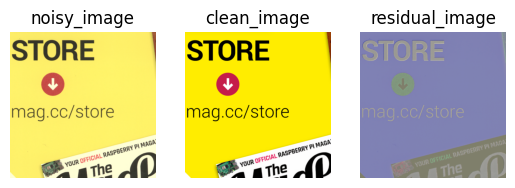

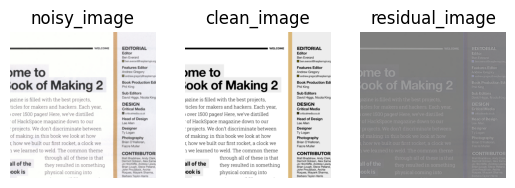

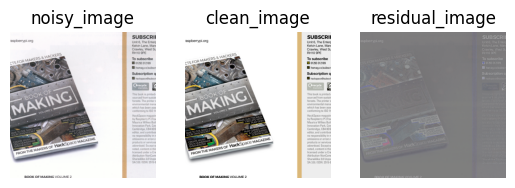

In [18]:
# 잔차 이미지 저장
for i, ((noisy_image, noisy_image_path), (clean_image, clean_image_path) ) in enumerate(zip(noisy_loader,clean_loader)):
    
    residual_image = noisy_image[0] - clean_image[0]
    residual_image = (residual_image * 0.5) + 0.5
    residual_image = torch.clamp(residual_image,0,1)

    noisy_image = transforms.ToPILImage()(noisy_image.squeeze(0))
    clean_image = transforms.ToPILImage()(clean_image.squeeze(0))
    residual_image = transforms.ToPILImage()(residual_image.squeeze(0))

    if(i<display_number):
        plt.subplot(1,3,1)
        plt.title("noisy_image")
        plt.imshow(noisy_image)
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.title("clean_image")
        plt.imshow(clean_image)
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.title("residual_image")
        plt.imshow(residual_image)
        plt.axis('off')
        plt.show()

    if output:
        output_filename = noisy_image_path[0]
        residual_filename = join(residual_output_dir , output_filename.split('\\')[-1][:-4].replace('\\',"/") + '.png')
        print_format = cv2.cvtColor(np.array(residual_image), cv2.COLOR_BGR2RGB)
        cv2.imwrite(residual_filename, print_format)

    

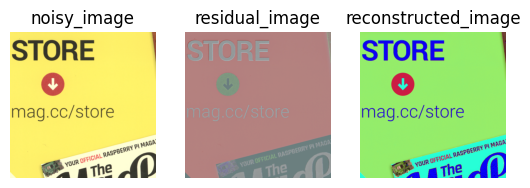

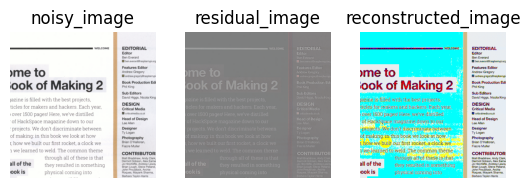

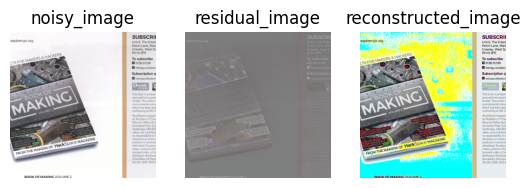

In [20]:
# RECONSTRUCTION CODE

residual_dataset = ImageDataset(residual_output_dir, transform= transforms.ToTensor())
residual_loader = DataLoader(residual_dataset, batch_size=1, shuffle=False)

for i, ((residual_image, residual_image_path),(noisy_image, noisy_image_path)) in enumerate(zip(residual_loader,noisy_loader)):

    residual = (residual_image - 0.5) * 2
    reconstructed_image = noisy_image - residual
    
    noisy_image = transforms.ToPILImage()(noisy_image.squeeze(0))
    residual_image = transforms.ToPILImage()(residual_image.squeeze(0))
    reconstructed_image = transforms.ToPILImage()(reconstructed_image.squeeze(0))

    if(i<display_number):
        plt.subplot(1,3,1)
        plt.title("noisy_image")
        plt.imshow(noisy_image)
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.title("residual_image")
        plt.imshow(residual_image)
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.title("reconstructed_image")
        plt.imshow(reconstructed_image)
        plt.axis('off')
        plt.show()    